In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel, AutoConfig
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns



In [4]:
# Load data
data1 = pd.read_csv('data1.csv')
data2 = pd.read_csv('data2.csv')
data3 = pd.read_csv('data3.csv')

# Load sentence segmentation model
tokenizer_seg = AutoTokenizer.from_pretrained("KoichiYasuoka/roberta-classical-chinese-base-sentence-segmentation")
model_seg = AutoModel.from_pretrained("KoichiYasuoka/roberta-classical-chinese-base-sentence-segmentation")

# Define the max length
MAX_LENGTH = 1024

# Load word embedding model with a specific max position embeddings setting
config = AutoConfig.from_pretrained("Jihuai/bert-ancient-chinese", max_position_embeddings=MAX_LENGTH)
tokenizer_embed = AutoTokenizer.from_pretrained("Jihuai/bert-ancient-chinese", model_max_length=MAX_LENGTH)
model_embed = AutoModel.from_pretrained("Jihuai/bert-ancient-chinese", config=config, ignore_mismatched_sizes=True)





/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/106k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/423M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at KoichiYasuoka/roberta-classical-chinese-base-sentence-segmentation and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/417 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/178k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/462M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at Jihuai/bert-ancient-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at Jihuai/bert-ancient-chinese and are newly initialized because the shapes did not match:
- bert.embeddings.position_embeddings.weight: found shape torch.Size([512, 768]) in the checkpoint and torch.Size([1024, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Function to filter sentences containing "仁" and count them
def filter_and_count_sentences_with_ren(df):
    filtered_df = df[df['segmented'].str.contains('仁')]
    count = filtered_df.shape[0]
    return filtered_df, count

# Filter sentences containing "仁" and count them
data1_filtered, data1_count = filter_and_count_sentences_with_ren(data1)
data2_filtered, data2_count = filter_and_count_sentences_with_ren(data2)
data3_filtered, data3_count = filter_and_count_sentences_with_ren(data3)

data1_filtered_head = data1_filtered.head()
data2_filtered_head = data2_filtered.head()
data3_filtered_head = data3_filtered.head()

data1_count, data2_count, data3_count, data1_filtered_head, data2_filtered_head, data3_filtered_head


(83,
 128,
 135,
        book chapter                                          segmented  \
 0  analects      学而  子 曰 学 而 时 习 之 不 亦 说 乎 有 朋 自 远 方 来 不 亦 乐 乎 人 不 ...   
 2  analects      八佾  孔子 谓 季 氏 八 佾 舞 于 庭 是 可 忍 也 孰 不 可 忍 也 三 家 者 以 雍...   
 3  analects      里仁  子 曰 里 仁 为 美 择 不 处 仁 焉 得 知 子 曰 不 仁 者 不 可 以 久 处 ...   
 4  analects     公冶长  子 谓 公冶 长 可 妻 也 虽 在 缧 绁 之 中 非 其 罪 也 以 其 子 妻 之 子...   
 5  analects      雍也  子 曰 雍 也 可 使 南 面 仲弓 问 子桑 伯子 子 曰 可 也 简 仲弓 曰 居 敬 ...   
 
    average_year  mapped_year  contain_ren  
 0          -415         1958            1  
 2          -415         1958            1  
 3          -415         1958            1  
 4          -415         1958            1  
 5          -415         1958            1  ,
         book chapter                                          segmented  \
 0  shuo-yuan      君道  晋 平 公 问 于 师 旷 曰 人 君 之 道 如 何 对 曰 人 君 之 道 清 净 无 ...   
 1  shuo-yuan      臣术  人 臣 之 术 顺 从 而 复 命 无 所 敢 专 义 不 苟 合 位 不 苟 尊 ； 必 ...   
 2  shuo-yuan      建本  孔子 曰 君子 务

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20161 (\N{CJK UNIFIED IDEOGRAPH-4EC1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


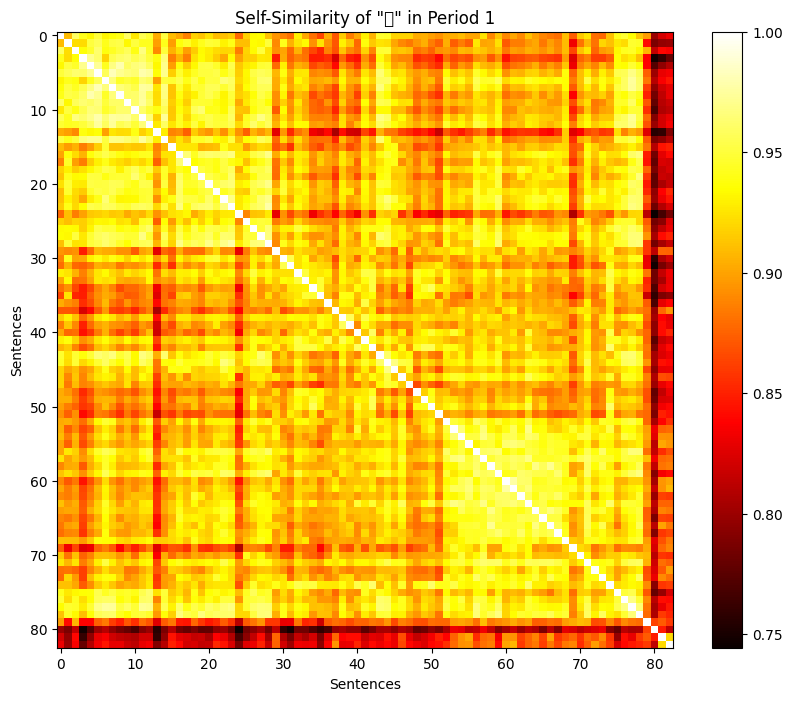

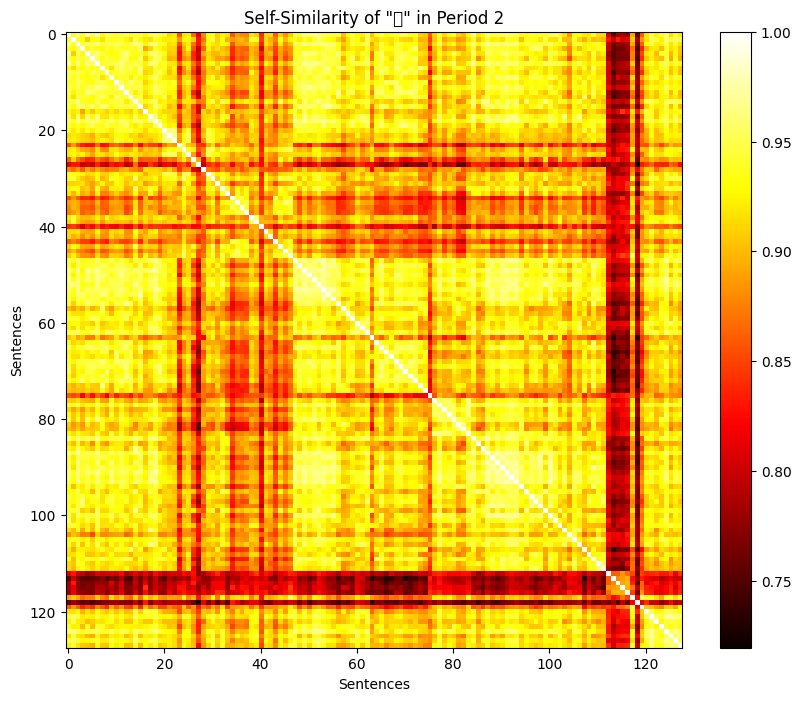

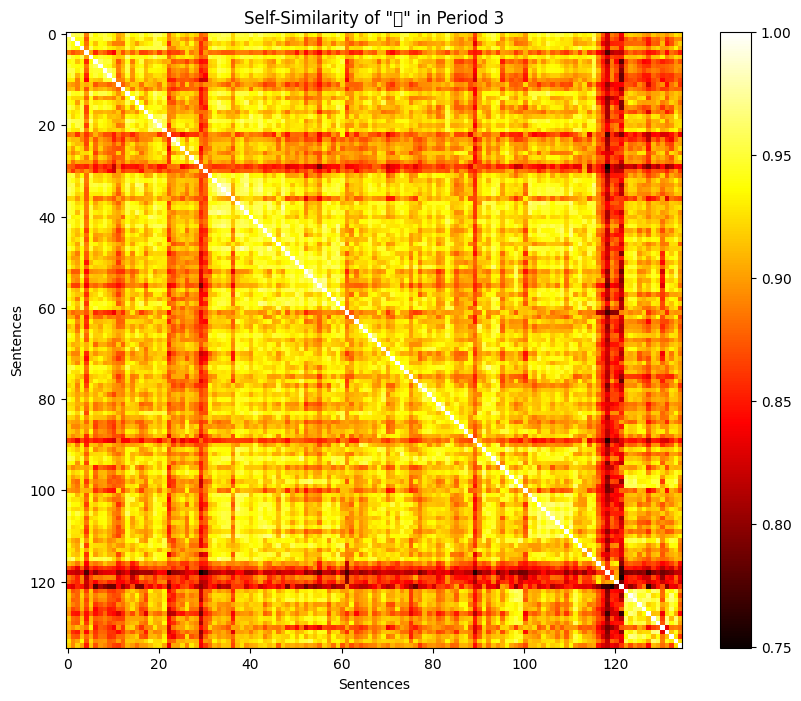

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20161 (\N{CJK UNIFIED IDEOGRAPH-4EC1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


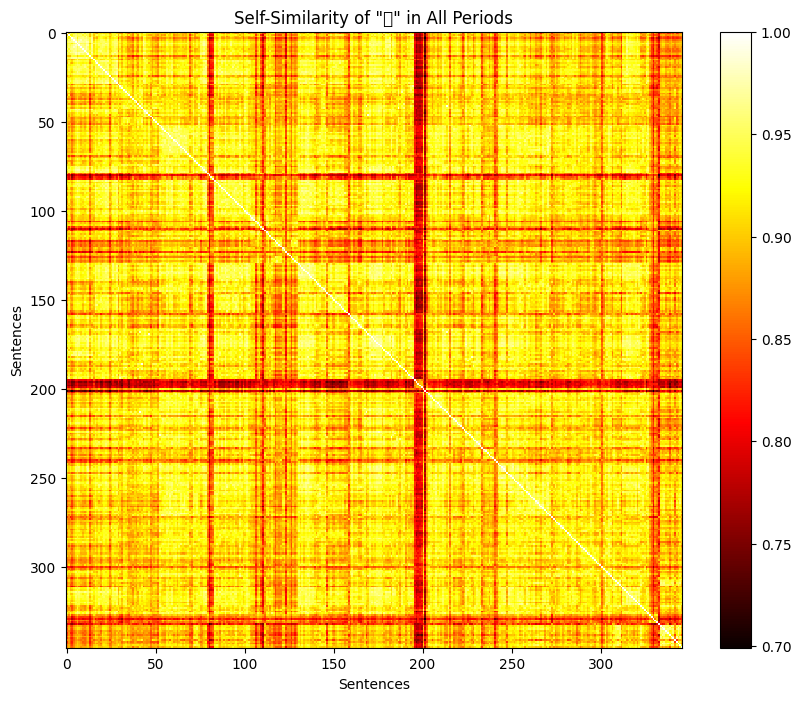

In [6]:
def get_embedding(text):
    inputs = tokenizer_embed(text, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LENGTH)
    with torch.no_grad():
        outputs = model_embed(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

def filter_sentences_with_ren(df):
    return df[df['segmented'].str.contains('仁')]

def compute_embeddings(df):
    embeddings = []
    for text in df['segmented']:
        embedding = get_embedding(text)
        embeddings.append(embedding)
    return embeddings

def compute_self_similarity(embeddings):
    return cosine_similarity(embeddings, embeddings)

# Filter sentences containing "仁"
data1_filtered = filter_sentences_with_ren(data1)
data2_filtered = filter_sentences_with_ren(data2)
data3_filtered = filter_sentences_with_ren(data3)

# Compute embeddings for each period
embeddings1 = compute_embeddings(data1_filtered)
embeddings2 = compute_embeddings(data2_filtered)
embeddings3 = compute_embeddings(data3_filtered)

# Compute self-similarity for each period
self_similarity1 = compute_self_similarity(embeddings1)
self_similarity2 = compute_self_similarity(embeddings2)
self_similarity3 = compute_self_similarity(embeddings3)

# Plot self-similarity for each period
def plot_self_similarity(matrix, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Sentences')
    plt.ylabel('Sentences')
    plt.show()

plot_self_similarity(self_similarity1, 'Self-Similarity of "仁" in Period 1')
plot_self_similarity(self_similarity2, 'Self-Similarity of "仁" in Period 2')
plot_self_similarity(self_similarity3, 'Self-Similarity of "仁" in Period 3')

# Compute and plot self-similarity for all sentences containing "仁"
all_embeddings = embeddings1 + embeddings2 + embeddings3
self_similarity_all = compute_self_similarity(all_embeddings)
plot_self_similarity(self_similarity_all, 'Self-Similarity of "仁" in All Periods')

# **Methods 2**



<ipython-input-13-22cf19497630>:69: UserWarning: Glyph 20161 (\N{CJK UNIFIED IDEOGRAPH-4EC1}) missing from current font.
  fig.tight_layout()
<ipython-input-13-22cf19497630>:69: UserWarning: Glyph 36132 (\N{CJK UNIFIED IDEOGRAPH-8D24}) missing from current font.
  fig.tight_layout()
<ipython-input-13-22cf19497630>:69: UserWarning: Glyph 31036 (\N{CJK UNIFIED IDEOGRAPH-793C}) missing from current font.
  fig.tight_layout()
<ipython-input-13-22cf19497630>:69: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.tight_layout()
<ipython-input-13-22cf19497630>:69: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  fig.tight_layout()
<ipython-input-13-22cf19497630>:69: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  fig.tight_layout()
<ipython-input-13-22cf19497630>:69: UserWarning: Glyph 32463 (\N{CJK UNIFIED IDEOGRAPH-7ECF}) missing from current font.
  fig.tight_layout()
<ipyth

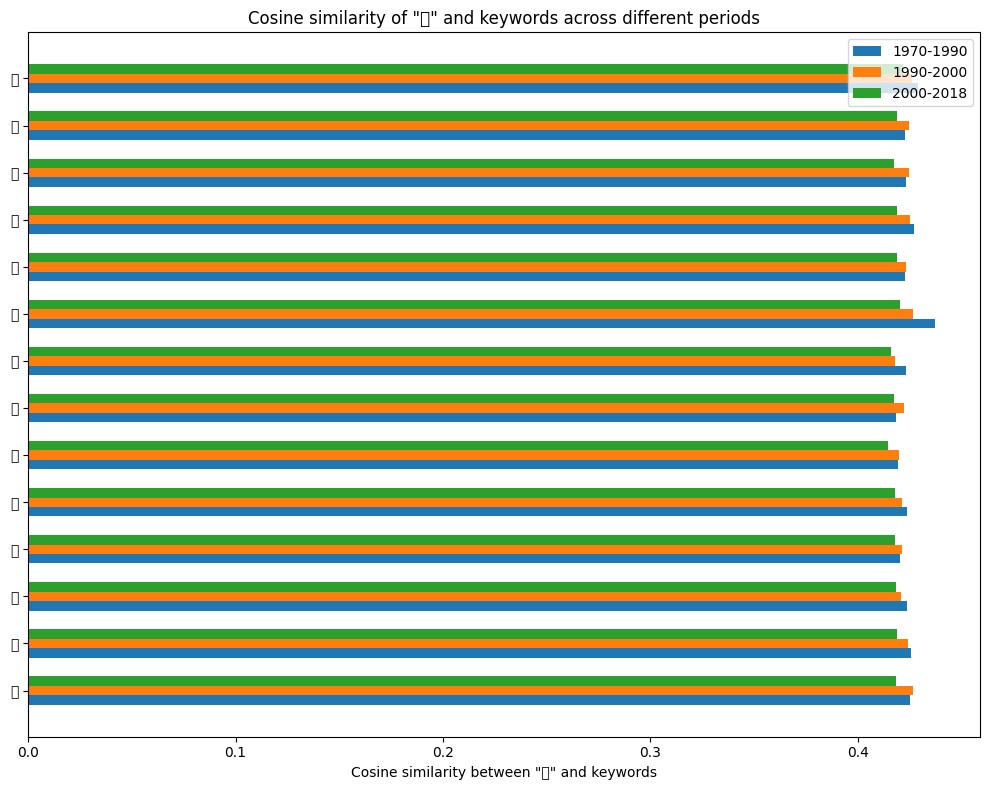

In [13]:
# 关键词列表
keywords = ["贤", "礼", "中", "和", "小", "经", "常", "伦", "孝", "正", "教", "圣", "尊", "亲"]

# 计算词嵌入的函数
def get_embedding(text):
    inputs = tokenizer_embed(text, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LENGTH)
    with torch.no_grad():
        outputs = model_embed(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# 计算关键词的平均词向量
def compute_average_embeddings(df, keywords):
    embeddings = {keyword: [] for keyword in keywords}
    for text in df['segmented']:
        sentences = text.split("。")
        for sentence in sentences:
            for keyword in keywords:
                if keyword in sentence:
                    embedding = get_embedding(sentence)
                    embeddings[keyword].append(embedding)

    avg_embeddings = {keyword: np.mean(embeddings[keyword], axis=0) for keyword in keywords if embeddings[keyword]}
    return avg_embeddings

# 计算每个时期的关键词平均词向量
avg_embeddings1 = compute_average_embeddings(data1, keywords)
avg_embeddings2 = compute_average_embeddings(data2, keywords)
avg_embeddings3 = compute_average_embeddings(data3, keywords)

# 获取“仁”的嵌入
ren_embedding1 = get_embedding("仁")
ren_embedding2 = get_embedding("仁")
ren_embedding3 = get_embedding("仁")

# 计算“仁”和关键词的相似度
def calculate_similarities(ren_embedding, avg_embeddings):
    similarities = {}
    for keyword, embedding in avg_embeddings.items():
        similarity = cosine_similarity([ren_embedding], [embedding])[0][0]
        similarities[keyword] = similarity
    return similarities

similarities1 = calculate_similarities(ren_embedding1, avg_embeddings1)
similarities2 = calculate_similarities(ren_embedding2, avg_embeddings2)
similarities3 = calculate_similarities(ren_embedding3, avg_embeddings3)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36132 (\N{CJK UNIFIED IDEOGRAPH-8D24}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31036 (\N{CJK UNIFIED IDEOGRAPH-793C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

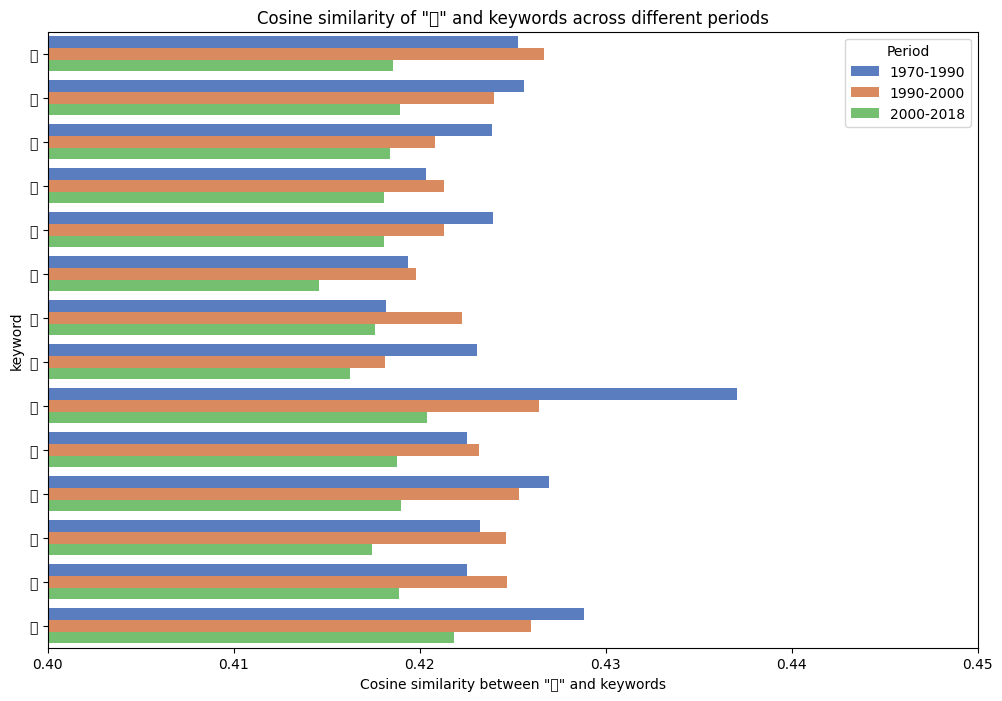

In [31]:
import seaborn as sns
# 准备绘图数据
data = {
    'keyword': keywords,
    '1970-1990': [similarities1.get(keyword, 0) for keyword in keywords],
    '1990-2000': [similarities2.get(keyword, 0) for keyword in keywords],
    '2000-2018': [similarities3.get(keyword, 0) for keyword in keywords]
}

df = pd.DataFrame(data)
df = df.melt(id_vars='keyword', var_name='period', value_name='similarity')

# 绘制图表
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='similarity', y='keyword', hue='period', palette='muted')
plt.xlabel('Cosine similarity between "仁" and keywords')
plt.title('Cosine similarity of "仁" and keywords across different periods')
plt.xlim(0.4, 0.45)
plt.legend(title='Period')
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36132 (\N{CJK UNIFIED IDEOGRAPH-8D24}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31036 (\N{CJK UNIFIED IDEOGRAPH-793C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

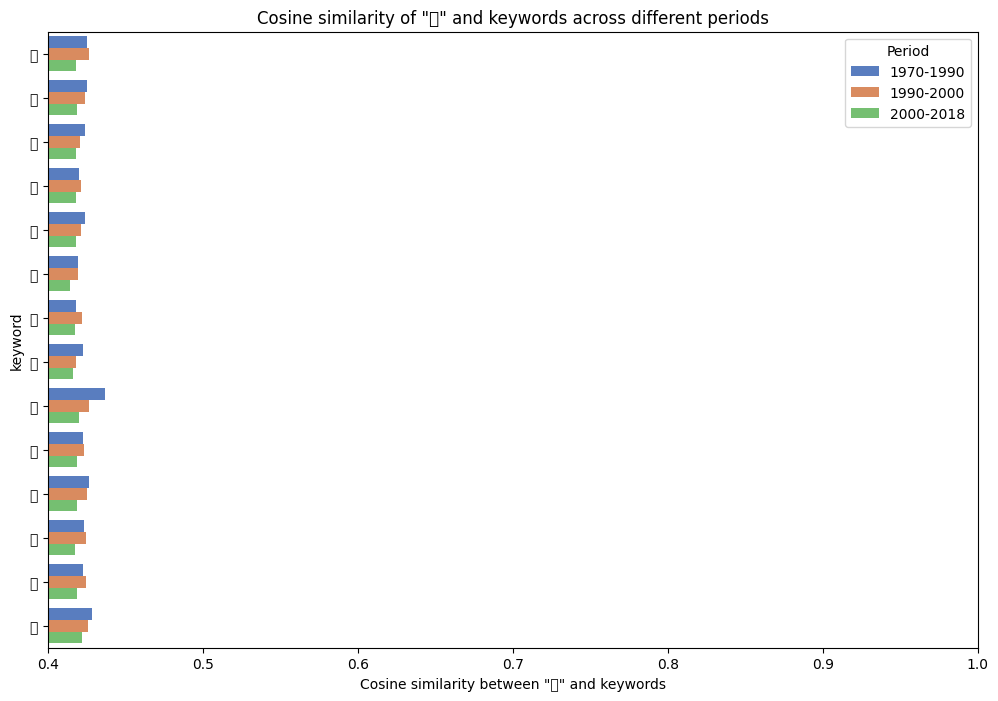

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20161 (\N{CJK UNIFIED IDEOGRAPH-4EC1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36132 (\N{CJK UNIFIED IDEOGRAPH-8D24}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31036 (\N{CJK UNIFIED IDEOGRAPH-793C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

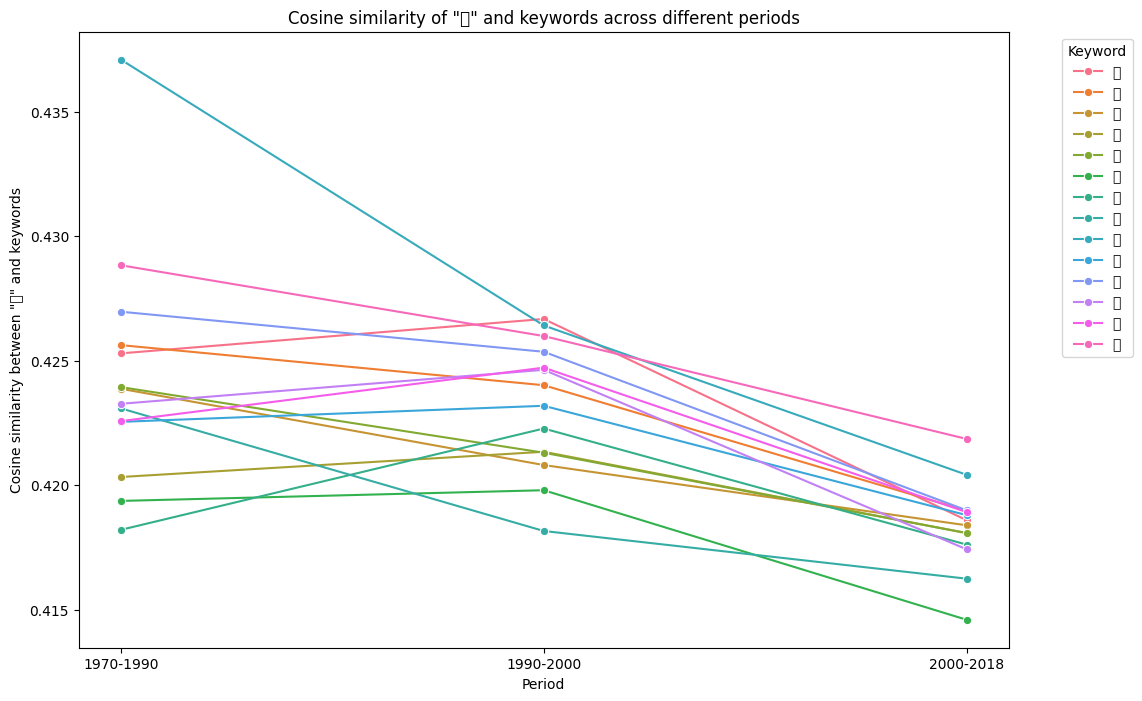

In [32]:
# 准备绘图数据
data = {
    'keyword': keywords,
    '1970-1990': [similarities1.get(keyword, 0) for keyword in keywords],
    '1990-2000': [similarities2.get(keyword, 0) for keyword in keywords],
    '2000-2018': [similarities3.get(keyword, 0) for keyword in keywords]
}

df = pd.DataFrame(data)
df = df.melt(id_vars='keyword', var_name='period', value_name='similarity')

# 绘制条形图
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='similarity', y='keyword', hue='period', palette='muted')
plt.xlabel('Cosine similarity between "仁" and keywords')
plt.title('Cosine similarity of "仁" and keywords across different periods')
plt.xlim(0.4, 1.0)
plt.legend(title='Period')
plt.show()

# 绘制折线图
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='period', y='similarity', hue='keyword', marker='o')
plt.xlabel('Period')
plt.ylabel('Cosine similarity between "仁" and keywords')
plt.title('Cosine similarity of "仁" and keywords across different periods')
plt.legend(title='Keyword', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 人伦

In [ ]:
# 关键词列表
keywords = ["贤", "礼", "中", "和", "小", "经", "常", "伦", "孝", "正", "教", "圣", "尊", "亲"]

# 计算词嵌入的函数
def get_embedding(text):
    inputs = tokenizer_embed(text, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LENGTH)
    with torch.no_grad():
        outputs = model_embed(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# 计算关键词的平均词向量
def compute_average_embeddings(df, keywords):
    embeddings = {keyword: [] for keyword in keywords}
    for text in df['segmented']:
        sentences = text.split("。")
        for sentence in sentences:
            for keyword in keywords:
                if keyword in sentence:
                    embedding = get_embedding(sentence)
                    embeddings[keyword].append(embedding)

    avg_embeddings = {keyword: np.mean(embeddings[keyword], axis=0) for keyword in keywords if embeddings[keyword]}
    return avg_embeddings

# 计算每个时期的关键词平均词向量
avg_embeddings1 = compute_average_embeddings(data1, keywords)
avg_embeddings2 = compute_average_embeddings(data2, keywords)
avg_embeddings3 = compute_average_embeddings(data3, keywords)

# 获取“仁”的嵌入
ren_embedding1 = get_embedding("仁")
ren_embedding2 = get_embedding("仁")
ren_embedding3 = get_embedding("仁")

# 计算“仁”和关键词的相似度
def calculate_similarities(ren_embedding, avg_embeddings):
    similarities = {}
    for keyword, embedding in avg_embeddings.items():
        similarity = cosine_similarity([ren_embedding], [embedding])[0][0]
        similarities[keyword] = similarity
    return similarities

similarities1 = calculate_similarities(ren_embedding1, avg_embeddings1)
similarities2 = calculate_similarities(ren_embedding2, avg_embeddings2)
similarities3 = calculate_similarities(ren_embedding3, avg_embeddings3)


In [1]:

# 准备绘图数据
data = {
    'keyword': keywords,
    '1970-1990': [similarities1.get(keyword, 0) for keyword in keywords],
    '1990-2000': [similarities2.get(keyword, 0) for keyword in keywords],
    '2000-2018': [similarities3.get(keyword, 0) for keyword in keywords]
}

df = pd.DataFrame(data)
df = df.melt(id_vars='keyword', var_name='period', value_name='similarity')

# 输出数据框内容以确认关键词顺序
print(df)
# 绘制柱状图
plt.figure(figsize=(14, 8))
sns.barplot(data=df, x='keyword', y='similarity', hue='period', palette='muted')
plt.xlabel('Keyword')
plt.ylabel('Cosine similarity between "仁" and keywords')
plt.ylim(0.4, 0.45)
plt.title('Cosine similarity of "仁" and keywords across different periods')
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

NameError: name 'keywords' is not defined

# *为政*
# 君 臣 天 命 道 德 父 子 妻 家 国 政 治 法 心

In [7]:
# 关键词列表
keywords = ["君","臣","天","命","道","德","父","子","妻","家","国","政","治","法","心"]

# 计算词嵌入的函数
def get_embedding(text):
    inputs = tokenizer_embed(text, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LENGTH)
    with torch.no_grad():
        outputs = model_embed(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# 计算关键词的平均词向量
def compute_average_embeddings(df, keywords):
    embeddings = {keyword: [] for keyword in keywords}
    for text in df['segmented']:
        sentences = text.split("。")
        for sentence in sentences:
            for keyword in keywords:
                if keyword in sentence:
                    embedding = get_embedding(sentence)
                    embeddings[keyword].append(embedding)

    avg_embeddings = {keyword: np.mean(embeddings[keyword], axis=0) for keyword in keywords if embeddings[keyword]}
    return avg_embeddings

# 计算每个时期的关键词平均词向量
avg_embeddings1 = compute_average_embeddings(data1, keywords)
avg_embeddings2 = compute_average_embeddings(data2, keywords)
avg_embeddings3 = compute_average_embeddings(data3, keywords)

# 获取“仁”的嵌入
ren_embedding1 = get_embedding("仁")
ren_embedding2 = get_embedding("仁")
ren_embedding3 = get_embedding("仁")

# 计算“仁”和关键词的相似度
def calculate_similarities(ren_embedding, avg_embeddings):
    similarities = {}
    for keyword, embedding in avg_embeddings.items():
        similarity = cosine_similarity([ren_embedding], [embedding])[0][0]
        similarities[keyword] = similarity
    return similarities

similarities1 = calculate_similarities(ren_embedding1, avg_embeddings1)
similarities2 = calculate_similarities(ren_embedding2, avg_embeddings2)
similarities3 = calculate_similarities(ren_embedding3, avg_embeddings3)


   keyword     period  similarity
0        君  1970-1990    0.598626
1        臣  1970-1990    0.596615
2        天  1970-1990    0.597582
3        命  1970-1990    0.592506
4        道  1970-1990    0.598006
5        德  1970-1990    0.598506
6        父  1970-1990    0.596990
7        子  1970-1990    0.600705
8        妻  1970-1990    0.593022
9        家  1970-1990    0.595347
10       国  1970-1990    0.594688
11       政  1970-1990    0.596878
12       治  1970-1990    0.597422
13       法  1970-1990    0.594736
14       心  1970-1990    0.596369
15       君  1990-2000    0.601547
16       臣  1990-2000    0.599952
17       天  1990-2000    0.602415
18       命  1990-2000    0.601109
19       道  1990-2000    0.600607
20       德  1990-2000    0.601322
21       父  1990-2000    0.600687
22       子  1990-2000    0.602280
23       妻  1990-2000    0.597422
24       家  1990-2000    0.599525
25       国  1990-2000    0.600987
26       政  1990-2000    0.598776
27       治  1990-2000    0.598800
28       法  19

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20161 (\N{CJK UNIFIED IDEOGRAPH-4EC1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21531 (\N{CJK UNIFIED IDEOGRAPH-541B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33251 (\N{CJK UNIFIED IDEOGRAPH-81E3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21629 (\N{CJK UNIFIED IDEOGRAPH-547D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

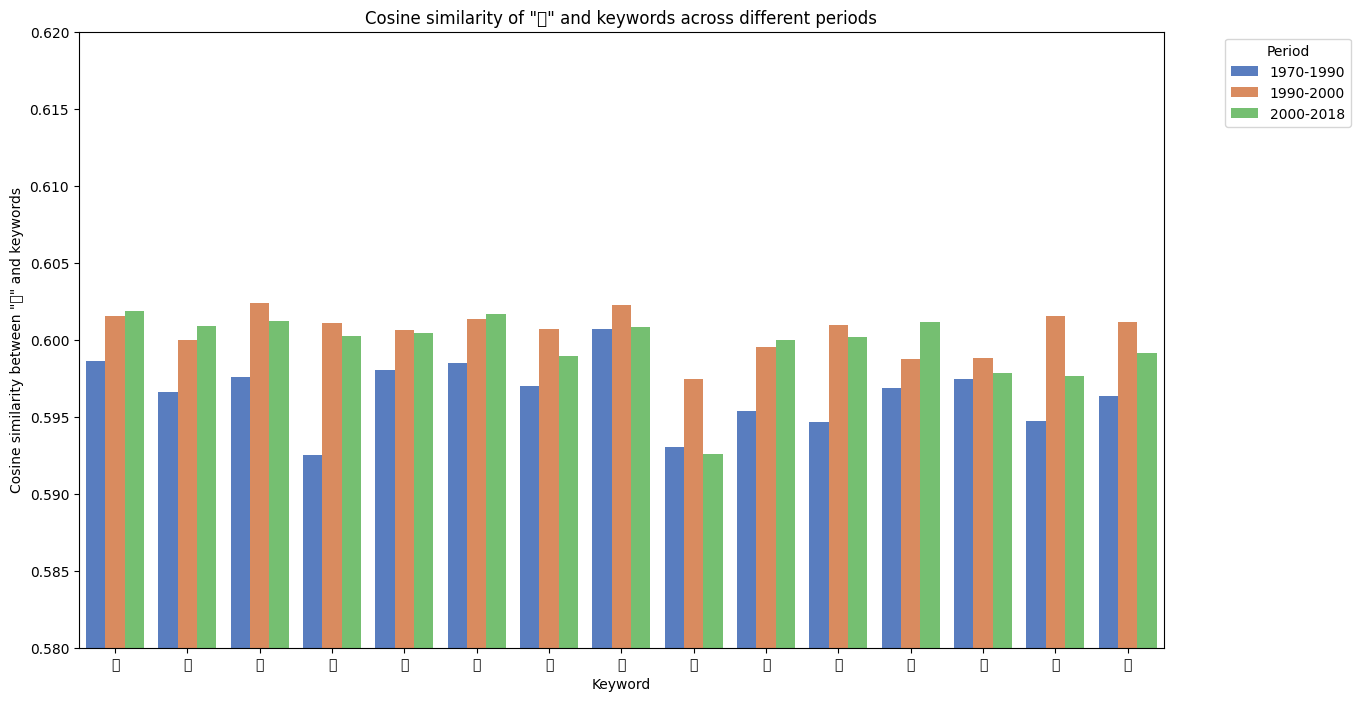

In [11]:
# 准备绘图数据
data = {
    'keyword': keywords,
    '1970-1990': [similarities1.get(keyword, 0) for keyword in keywords],
    '1990-2000': [similarities2.get(keyword, 0) for keyword in keywords],
    '2000-2018': [similarities3.get(keyword, 0) for keyword in keywords]
}

df = pd.DataFrame(data)
df = df.melt(id_vars='keyword', var_name='period', value_name='similarity')

# 输出数据框内容以确认关键词顺序
print(df)
# 绘制柱状图
plt.figure(figsize=(14, 8))
sns.barplot(data=df, x='keyword', y='similarity', hue='period', palette='muted')
plt.xlabel('Keyword')
plt.ylabel('Cosine similarity between "仁" and keywords')
plt.ylim(0.58, 0.62)
plt.title('Cosine similarity of "仁" and keywords across different periods')
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 人生
# 善 恶 义 知 信 性 欲 有 无 修 齐 贵 贱 人 生

In [12]:
# 关键词列表
keywords = ["善","恶","义","知","信","性","欲","有","无","修","齐","贵","贱","人","生"]

# 计算词嵌入的函数
def get_embedding(text):
    inputs = tokenizer_embed(text, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LENGTH)
    with torch.no_grad():
        outputs = model_embed(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# 计算关键词的平均词向量
def compute_average_embeddings(df, keywords):
    embeddings = {keyword: [] for keyword in keywords}
    for text in df['segmented']:
        sentences = text.split("。")
        for sentence in sentences:
            for keyword in keywords:
                if keyword in sentence:
                    embedding = get_embedding(sentence)
                    embeddings[keyword].append(embedding)

    avg_embeddings = {keyword: np.mean(embeddings[keyword], axis=0) for keyword in keywords if embeddings[keyword]}
    return avg_embeddings

# 计算每个时期的关键词平均词向量
avg_embeddings1 = compute_average_embeddings(data1, keywords)
avg_embeddings2 = compute_average_embeddings(data2, keywords)
avg_embeddings3 = compute_average_embeddings(data3, keywords)

# 获取“仁”的嵌入
ren_embedding1 = get_embedding("仁")
ren_embedding2 = get_embedding("仁")
ren_embedding3 = get_embedding("仁")

# 计算“仁”和关键词的相似度
def calculate_similarities(ren_embedding, avg_embeddings):
    similarities = {}
    for keyword, embedding in avg_embeddings.items():
        similarity = cosine_similarity([ren_embedding], [embedding])[0][0]
        similarities[keyword] = similarity
    return similarities

similarities1 = calculate_similarities(ren_embedding1, avg_embeddings1)
similarities2 = calculate_similarities(ren_embedding2, avg_embeddings2)
similarities3 = calculate_similarities(ren_embedding3, avg_embeddings3)


   keyword     period  similarity
0        善  1970-1990    0.595703
1        恶  1970-1990    0.597846
2        义  1970-1990    0.596717
3        知  1970-1990    0.594927
4        信  1970-1990    0.594740
5        性  1970-1990    0.593754
6        欲  1970-1990    0.593675
7        有  1970-1990    0.597657
8        无  1970-1990    0.598334
9        修  1970-1990    0.595228
10       齐  1970-1990    0.593486
11       贵  1970-1990    0.594854
12       贱  1970-1990    0.593550
13       人  1970-1990    0.599890
14       生  1970-1990    0.594900
15       善  1990-2000    0.602264
16       恶  1990-2000    0.599496
17       义  1990-2000    0.601080
18       知  1990-2000    0.598937
19       信  1990-2000    0.601340
20       性  1990-2000    0.598041
21       欲  1990-2000    0.599720
22       有  1990-2000    0.602445
23       无  1990-2000    0.601662
24       修  1990-2000    0.598591
25       齐  1990-2000    0.600061
26       贵  1990-2000    0.599247
27       贱  1990-2000    0.597454
28       人  19

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20161 (\N{CJK UNIFIED IDEOGRAPH-4EC1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21892 (\N{CJK UNIFIED IDEOGRAPH-5584}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24694 (\N{CJK UNIFIED IDEOGRAPH-6076}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20041 (\N{CJK UNIFIED IDEOGRAPH-4E49}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30693 (\N{CJK UNIFIED IDEOGRAPH-77E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

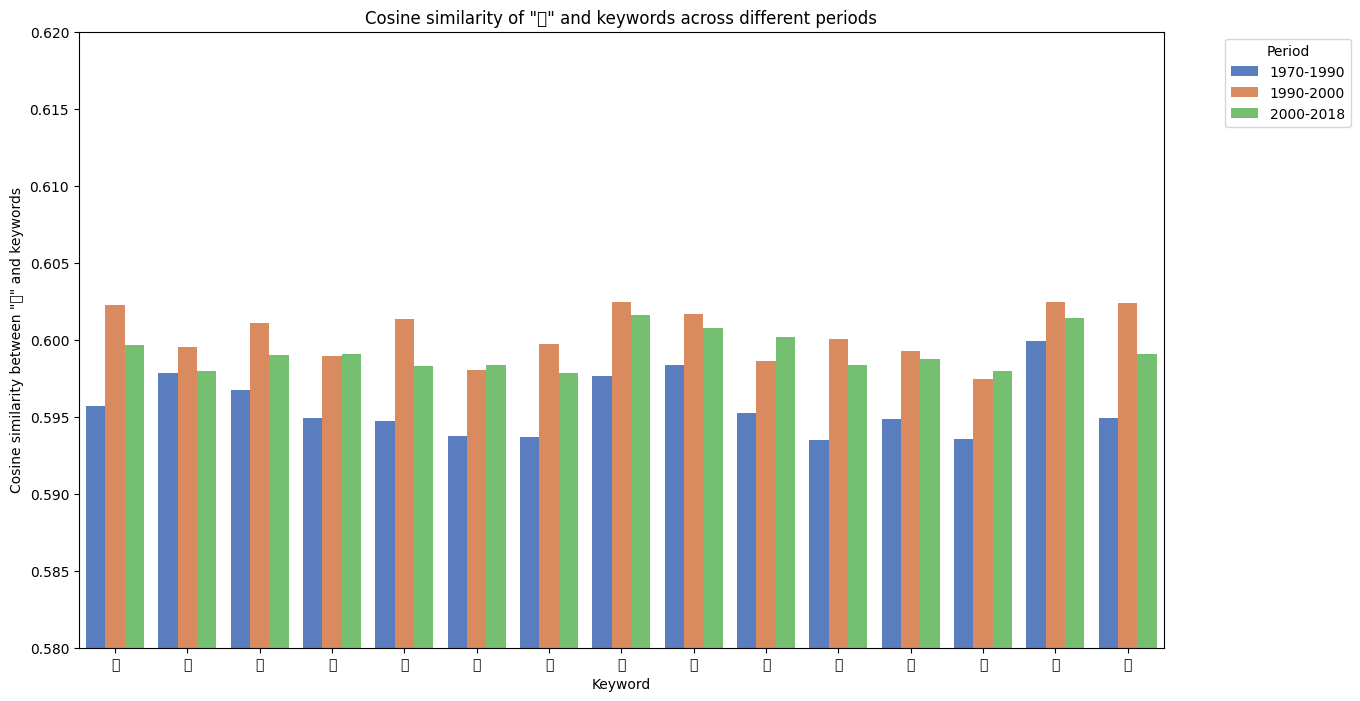

In [17]:
# 准备绘图数据
data = {
    'keyword': keywords,
    '1970-1990': [similarities1.get(keyword, 0) for keyword in keywords],
    '1990-2000': [similarities2.get(keyword, 0) for keyword in keywords],
    '2000-2018': [similarities3.get(keyword, 0) for keyword in keywords]
}

df = pd.DataFrame(data)
df = df.melt(id_vars='keyword', var_name='period', value_name='similarity')

# 输出数据框内容以确认关键词顺序
print(df)
# 绘制柱状图
plt.figure(figsize=(14, 8))
sns.barplot(data=df, x='keyword', y='similarity', hue='period', palette='muted')
plt.xlabel('Keyword')
plt.ylabel('Cosine similarity between "仁" and keywords')
plt.ylim(0.58, 0.62)
plt.title('Cosine similarity of "仁" and keywords across different periods')
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()